In [194]:
import skfuzzy as fuzz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
import timeit

from sklearn import preprocessing
%matplotlib inline

In [195]:
# Configure some general styling
sns.set_style("white")
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.figsize'] = (8,7)

colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

<h2>Filter data</h2>

In [196]:
# import data 
dataset = pd.read_csv('../input/all_data.csv')

# rename columns to a better format
dataset.rename(columns={
                    'Temp.': 'temp',
                    'Rel. Hum.': 'humidity',
                    'Par. Dis.': 'partial_discharge',
                    'Vibr. Lev.': 'vibration',
                    'Audio 1': 'audio',
                    'Video 1': 'video',
                    'Bushing Condition': 'condition'},
                    inplace=True)

# remove any output files previously created when checking for invalid data
for column in dataset.columns.values:
    filepath = 'output/invalid_' + column + '.txt'
    if os.path.exists(filepath):
        os.remove(filepath)

In [197]:
def output_invalid_number(col, ind, val):
    """Output the index and value of an invalid value to a .txt file
    
    col -- the column the value exists in
    ind -- the index the value is at in the dataset
    val -- the value
    """
    f = open('output/invalid_' + col + '.txt', 'a+')
    f.write(str(ind) + ',' + str(val) + '\n')
    return np.NaN

In [198]:
def output_invalid_condition(ind, val):
    """Output the index and value of an invalid condition to a .txt file
    
    ind -- the index the value is at in the dataset
    val -- the value
    """
    f = open('output/invalid_condition.txt', 'a+')
    f.write(str(ind) + ',' + str(val) + '\n')
    return None

In [199]:
## convert non numeric values to NaN
dataset['temp'] = pd.to_numeric(dataset['temp'], errors='coerce')
dataset['humidity'] = pd.to_numeric(dataset['humidity'], errors='coerce')
dataset['partial_discharge'] = pd.to_numeric(dataset['partial_discharge'], errors='coerce')
dataset['vibration'] = pd.to_numeric(dataset['vibration'], errors='coerce')

In [200]:
## convert values to NaN if not in the specified range
# temperature between 19 and 31
dataset['temp'] = [val if (19 <= val <= 31) else output_invalid_number('temp', ind, val) for ind, val in enumerate(dataset['temp'])]

# relative humidity between 44 and 66
dataset['humidity'] = [val if (44 <= val <= 66) else output_invalid_number('humidity', ind, val) for ind, val in enumerate(dataset['humidity'])]

# partial discharge between 1 and 20
dataset['partial_discharge'] = [val if (1 <= val <= 66) else output_invalid_number('partial_discharge', ind, val) for ind, val in enumerate(dataset['partial_discharge'])]

# vibration level 0, 1, or 5
dataset['vibration'] = [val if (val == 0 or val == 1 or val == 5) else output_invalid_number('vibration', ind, val) for ind, val in enumerate(dataset['vibration'])]
# vibration level --> replace 5 with 1
dataset['vibration'] = dataset['vibration'].replace(5, 1)

# audio between 10 and 84
dataset['audio'] = [val if (10 <= val <= 84) else output_invalid_number('audio', ind, val) for ind, val in enumerate(dataset['audio'])]

In [201]:
conditions = [
    'good',
    'internal electrical insulation failure',
    'mechanical failure',
    'both electrical and mechanical failure',
]

# convert to lower case for comparison to conditions list
dataset['condition'] = dataset['condition'].str.lower()
# filter the condtions to None if not in the conditions list
dataset['condition'] = [val if val in conditions else output_invalid_condition(ind, val) for ind, val in enumerate(dataset['condition'])]

In [202]:
# dataset = dataset.drop(columns=['condition', 'video'])
labelled = dataset.dropna(axis=0, how='any').drop(columns=['condition', 'video'])

Commented code uses scaled data. Identifies the correct 4 cluster centers but I don't know how to keep the scale the same when inlcuding new data. This version uses only vibration and partial discharge. Should include audio to have a more accurate model.

In [203]:
scaler = preprocessing.MinMaxScaler()
# labelled = preprocessing.scale(labelled)
# xpts = labelled['vibration']
# ypts = labelled['partial_discharge']
labelled = scaler.fit_transform(labelled)
xpts = labelled[:,3]
ypts = labelled[:,2]

Visualize raw data

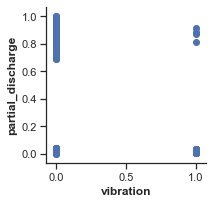

In [204]:
import seaborn
seaborn.set(style='ticks')

pardis_vibr = pd.DataFrame({
    'partial_discharge': ypts,
    'vibration': xpts
})
fg = seaborn.FacetGrid(data=pardis_vibr)
fg.map(plt.scatter, 'vibration', 'partial_discharge').add_legend()

Visualize the locations of cluster centers and their FPC value --> closer to 1 is best

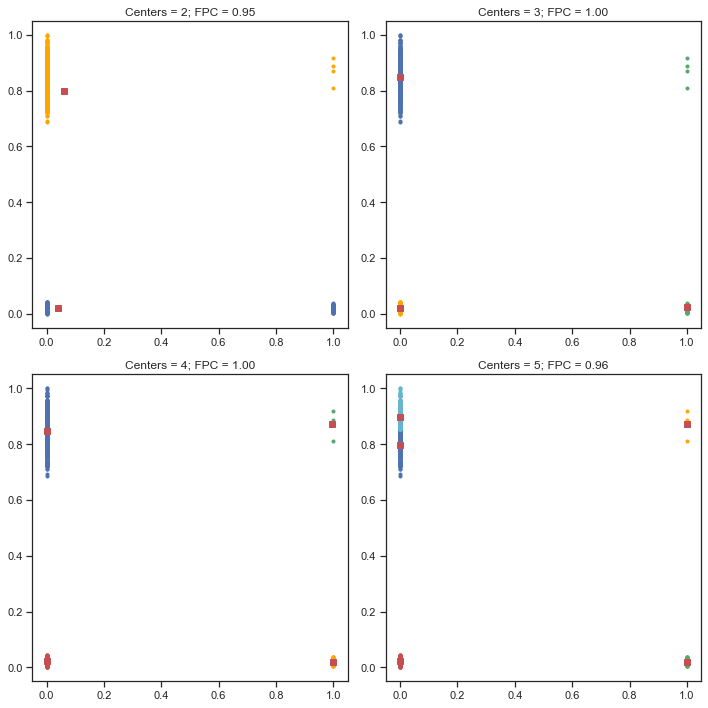

In [205]:
fig1, axes1 = plt.subplots(2, 2, figsize=(10, 10))
alldata = np.vstack((xpts, ypts))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))

fig1.tight_layout()

Visualize the model using a set amount of clusters -> 4 in this case

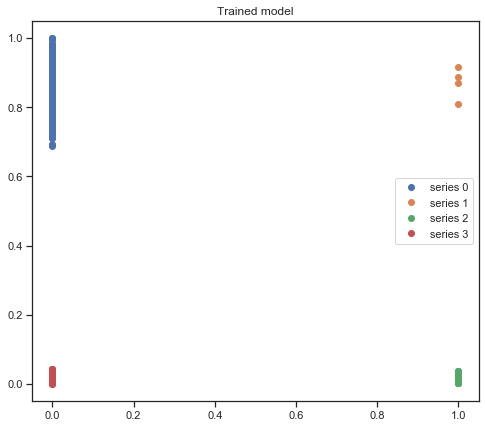

In [206]:
clusters = 4
# Regenerate fuzzy model with 4 cluster centers - note that center ordering
# is random in this clustering algorithm, so the centers may change places
cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(
    alldata, clusters, 2, error=0.005, maxiter=1000)

# Show 4-cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('Trained model')
for j in range(clusters):
    ax2.plot(alldata[0, u_orig.argmax(axis=0) == j],
             alldata[1, u_orig.argmax(axis=0) == j], 'o',
             label='series ' + str(j))
ax2.legend()

In [207]:
df_unlabelled = pd.read_csv('../input/unlabeled_data.csv')
# xpts_unlabelled = df_unlabelled['VibrLev']
# ypts_unlabelled = df_unlabelled['ParDis']
df_unlabelled = scaler.transform(df_unlabelled.drop(columns=['Condition']))
#df_unlabelled = preprocessing.scale(df_unlabelled.drop(columns=['Condition']))
xpts_unlabelled = df_unlabelled[:,2]
ypts_unlabelled = df_unlabelled[:,3]

## define centers manually for testing, comment out to use cntr values retrieved from algorithm
## cntr = np.array([[0,15],[0, 1],[1,1],[1,15]])

## combine data into single variable
unlabelled_data = np.vstack((xpts_unlabelled, ypts_unlabelled))

## predict classes of unlabelled data
u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(
    unlabelled_data, cntr, 2, error=0.005, maxiter=1000)

cluster_membership = np.argmax(u, axis=0)  # Hardening for visualization

Visualize raw unlabelled data

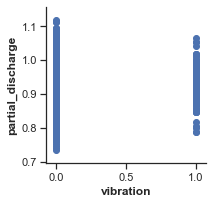

In [208]:
pardis_vibr = pd.DataFrame({
    'partial_discharge': xpts_unlabelled,
    'vibration': ypts_unlabelled
})
fg = seaborn.FacetGrid(data=pardis_vibr)
fg.map(plt.scatter, 'vibration', 'partial_discharge').add_legend()

Visualize predicted values for unlabelled data

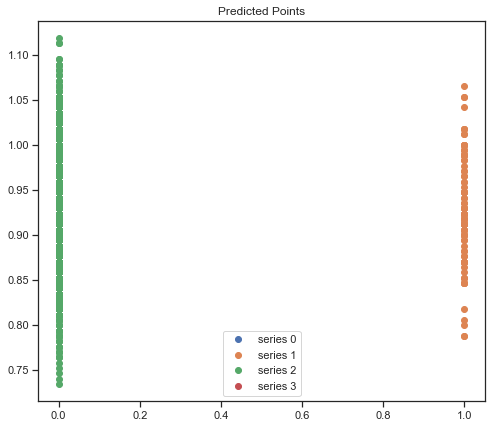

In [209]:
fig3, ax3 = plt.subplots()
ax3.set_title('Predicted Points')
for j in range(clusters):
    ax3.plot(unlabelled_data[1, u.argmax(axis=0) == j],
             unlabelled_data[0, u.argmax(axis=0) == j], 'o',
             label='series ' + str(j))
ax3.legend()

In [210]:
print('cntr:\n---------')
print(cntr)
print('u:\n---------')
print(u)
print('u0:\n---------')
print(u0)
print('d:\n---------')
print(d)
print('jm:\n---------')
print(jm)
print('p:\n---------')
print(p)
print('fpc:\n---------')
print(fpc)
print('cluster_membership:\n---------')
print(cluster_membership)

cntr:
---------
[[3.73971003e-08 8.48032534e-01]
 [9.95955322e-01 8.71394891e-01]
 [9.99971140e-01 1.96995188e-02]
 [4.17052810e-09 2.20360871e-02]]
u:
---------
[[1.97236336e-03 2.05544273e-02 4.15882143e-04 ... 1.15974033e-03
  2.85642884e-03 3.36878671e-03]
 [4.18307024e-03 3.63449633e-02 9.22089275e-04 ... 2.74730580e-03
  5.96437379e-03 6.97861999e-03]
 [9.90291727e-01 9.00731020e-01 9.97936525e-01 ... 9.94165027e-01
  9.85975637e-01 9.83480338e-01]
 [3.55283944e-03 4.23695891e-02 7.25503815e-04 ... 1.92792652e-03
  5.20355993e-03 6.17225562e-03]]
u0:
---------
[[0.17682393 0.23962685 0.18334216 ... 0.06140989 0.57933429 0.3372715 ]
 [0.00193868 0.15380125 0.48464786 ... 0.45570976 0.18862357 0.14505781]
 [0.58077372 0.48131288 0.28357699 ... 0.05536091 0.21512068 0.39157396]
 [0.24046367 0.12525902 0.04843299 ... 0.42751945 0.01692146 0.12609673]]
d:
---------
[[1.27104127 1.18144561 1.29768713 ... 1.34300556 1.26225596 1.257882  ]
 [0.87278151 0.88847314 0.87150252 ... 0.8725788

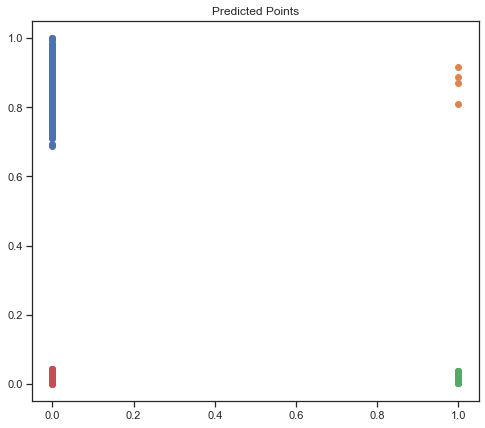

In [211]:
u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(
    alldata, cntr, 2, error=0.005, maxiter=1000)

fig4, ax4 = plt.subplots()
ax4.set_title('Predicted Points')
for j in range(clusters):
    ax4.plot(alldata[0, u.argmax(axis=0) == j],
             alldata[1, u.argmax(axis=0) == j], 'o',
             label='series ' + str(j))